In [9]:
import numpy as np 
import pandas as pd 
import os
import tsfresh as tf
import scipy
import time
import csv
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp

from scipy import stats
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from numpy.fft import fft, ifft
from sklearn.feature_selection import VarianceThreshold
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction import ComprehensiveFCParameters
from typing import Tuple
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

def plot_confusion_matrix(cm, title='Confusion matrix', cmap='Pastel1'):
    plt.figure(figsize=(9,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ["0", "1", "2", "3", "4"], rotation=45)
    plt.yticks(tick_marks, ["0", "1", "2", "3", "4"])
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    width, height = cm.shape
    plt.colorbar()

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

## Data Organization

In [2]:

path = './mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [3]:
# read files
filenames = next(os.walk(path))[2]

records = list()
annotations = list()
filenames.sort()

In [4]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [5]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        
            # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(100012, 360) (100012,)


In [6]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


In [7]:
X_df = pd.DataFrame(X)
#converting uV to mV
print('This is what the df looks like, where 0-359 is the time in ms and row # is the sample number')
X_df.head()

This is what the df looks like, where 0-359 is the time in ms and row # is the sample number


,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,957,956,961,964,964,966,965,966,967,969,...,957,958,958,955,955,955,960,958,957,0
1,950,951,952,951,956,959,961,960,958,958,...,948,950,952,951,952,951,948,950,951,0
2,946,949,952,956,957,958,957,957,959,960,...,957,957,958,957,956,957,960,956,956,0
3,960,961,960,959,961,965,967,964,965,967,...,956,958,960,961,959,957,953,955,956,0
4,939,940,943,948,950,951,951,951,955,958,...,962,962,962,958,957,958,960,959,959,0


Text(0, 0.5, 'Amplitude (mV)')

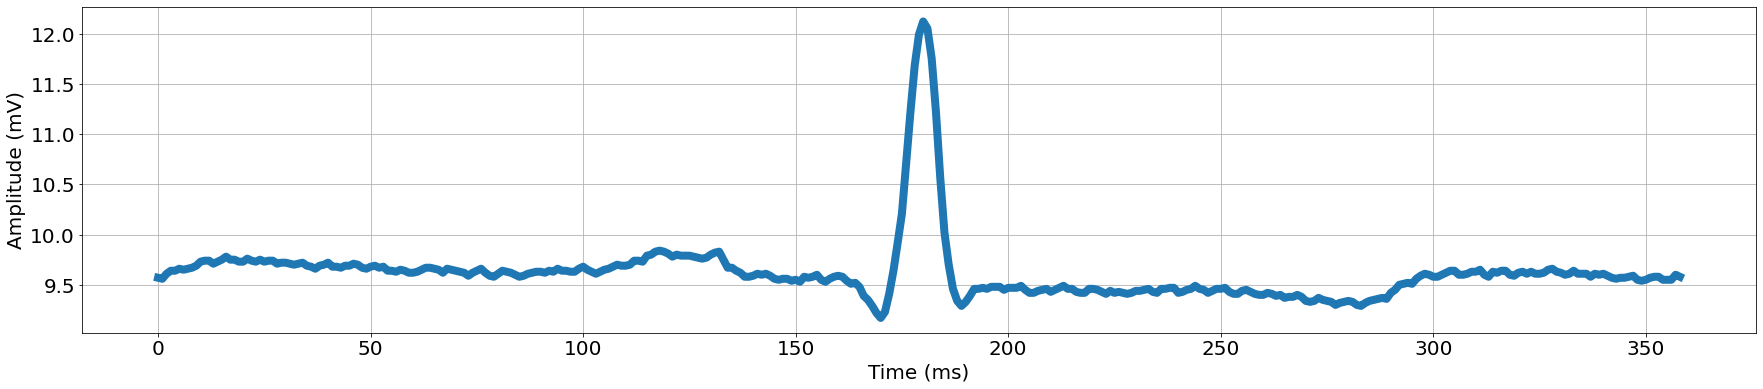

In [10]:
#print an example beat in mV
ex = X_df/100
ex.iloc[0,0:359].plot(linewidth=8)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')

0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


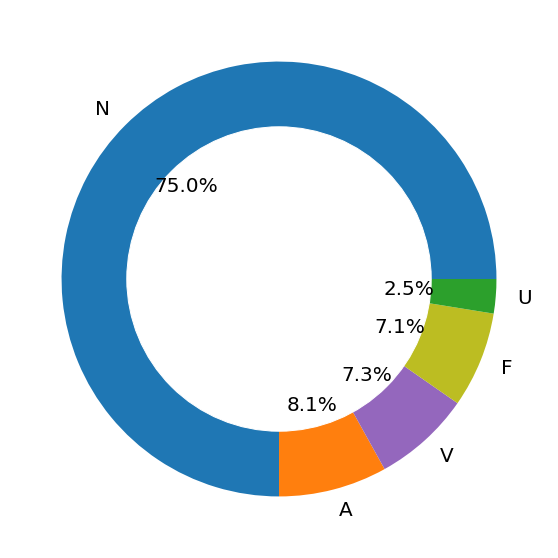

In [11]:
#data distribution before resampling
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [12]:
#resample the data so that there are equal amounts of each category
df_1=X_df[X_df[X_df.shape[1]-1]==1]
df_2=X_df[X_df[X_df.shape[1]-1]==2]
df_3=X_df[X_df[X_df.shape[1]-1]==3]
df_4=X_df[X_df[X_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_df[X_df[X_df.shape[1]-1]==0]).sample(n=6000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=6000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=6000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0    6000
1    6000
2    6000
3    6000
4    6000
Name: 360, dtype: int64


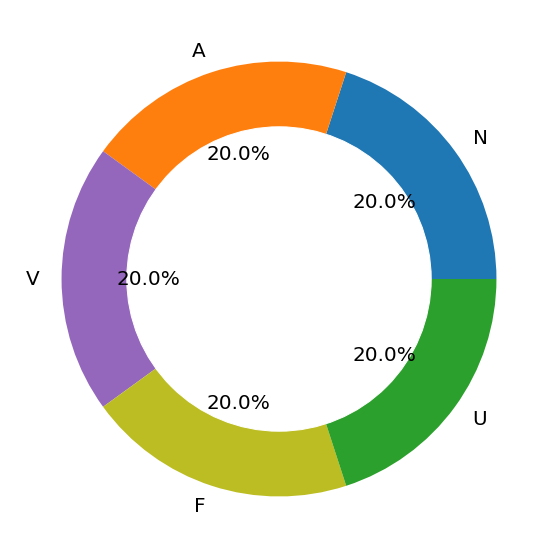

In [13]:
#show redistribution of data
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [14]:
category = X_df[360]
#change units from uV to mV
X_df = X_df/100

In [15]:
#iterate over rows to calculate features by row

n_rows = np.arange(0,30000,1)
skewness = []
entropy =[]
variance = []
duplicate_max = []
abssum_changes = []
abs_energy = []
kurtosis = []
benford = []
minmax_dis_abs = []
minmax_dis = []
peak_location = []
peak_width = []
peak_time = []
upper = []
lower = []
mean_2deriv = []
rmse = []
start = time.time()
for r in n_rows:
    
    s = tf.feature_extraction.feature_calculators.skewness(X_df.iloc[r,:])
    skewness.append(s)
    
    e = tf.feature_extraction.feature_calculators.sample_entropy(X_df.iloc[r,:])
    entropy.append(e)
    
    v = tf.feature_extraction.feature_calculators.variance(X_df.iloc[r,:])
    variance.append(v)
    
    d = tf.feature_extraction.feature_calculators.has_duplicate_max(X_df.iloc[r,:])
    duplicate_max.append(d)
    
    c = tf.feature_extraction.feature_calculators.absolute_sum_of_changes(X_df.iloc[r,:])
    abssum_changes.append(c)
    
    q = tf.feature_extraction.feature_calculators.abs_energy(X_df.iloc[r,:])
    abs_energy.append(q) 
    
    k = tf.feature_extraction.feature_calculators.kurtosis(X_df.iloc[r,:])
    kurtosis.append(k)
    
    b = tf.feature_extraction.feature_calculators.benford_correlation(X_df.iloc[r,:])
    benford.append(b)
    
    msd = tf.feature_extraction.feature_calculators.mean_second_derivative_central(X_df.iloc[r,:])
    mean_2deriv.append(msd)
    
    re = tf.feature_extraction.feature_calculators.root_mean_square(X_df.iloc[r,:])
    rmse.append(re)
    
    m = X_df.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis_abs = abs(maxm-minm)
    minmax_dis_abs.append(dis_abs)
    
    m = X_df.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis = (maxm-minm)
    minmax_dis.append(dis)
    
    pl = (X_df.iloc[r,:].sort_values(ascending=False).iloc[0])
    peak_location.append(pl)
    
    pw = (X_df.iloc[r,:].sort_values(ascending=False).iloc[0]) - (X_df.iloc[r,:].sort_values(ascending=False).iloc[1])
    peak_width.append(pw)
    
    pt = (X_df.iloc[r,:].sort_values(ascending=False).index[0] - X_df.iloc[r,:].sort_values(ascending=False).index[1])
    peak_time.append(pt)
    
    u = len(X_df.iloc[r,:][X_df.iloc[r,:] > ((X_df.iloc[r,:].max() - X_df.iloc[r,:].min())/2 + X_df.iloc[r,:].min())])
    upper.append(u)
    
    l = len(X_df.iloc[r,:][X_df.iloc[r,:] < ((X_df.iloc[r,:].max() - X_df.iloc[r,:].min())/2 - X_df.iloc[r,:].min())])
    lower.append(l)
    
    end = time.time()
    
    
    if (r % 10000 == 0) or (r == 0):
        print('On Row: ',r,'Time Elapsed: ',((end - start)/60),' min')

On Row:  0 Time Elapsed:  0.000509333610534668  min
On Row:  10000 Time Elapsed:  3.8742058356602986  min
On Row:  20000 Time Elapsed:  7.740711383024851  min


In [16]:
#create the feature table

feat_table = pd.DataFrame()

feat_table['beat_avg'] = X_df.mean(axis=1)
feat_table['beat_std'] = X_df.std(axis=1)
feat_table['beat_max'] = X_df.max(axis=1)
feat_table['beat_min'] = X_df.min(axis=1)
feat_table['beat_range'] = feat_table['beat_max'] - feat_table['beat_min']
feat_table['beat_ratio'] = feat_table['beat_min']/feat_table['beat_max']

#features by each quarter of beat
feat_table['qtr1_avg'] = X_df.iloc[:,0:90].mean(axis=1)
feat_table['qtr1_std'] = X_df.iloc[:,0:90].std(axis=1)
feat_table['qtr1_max'] = X_df.iloc[:,0:90].max(axis=1)
feat_table['qtr1_min'] = X_df.iloc[:,0:90].min(axis=1)
feat_table['qtr1_var'] = X_df.iloc[:,0:90].var(axis=1)

feat_table['qtr2_avg'] = X_df.iloc[:,91:179].mean(axis=1)
feat_table['qtr2_std'] = X_df.iloc[:,91:179].std(axis=1)
feat_table['qtr2_max'] = X_df.iloc[:,91:179].max(axis=1)
feat_table['qtr2_min'] = X_df.iloc[:,91:179].min(axis=1)
feat_table['qtr2_var'] = X_df.iloc[:,91:179].var(axis=1)

feat_table['qtr3_avg'] = X_df.iloc[:,180:269].mean(axis=1)
feat_table['qtr3_std'] = X_df.iloc[:,180:269].std(axis=1)
feat_table['qtr3_max'] = X_df.iloc[:,180:269].max(axis=1)
feat_table['qtr3_min'] = X_df.iloc[:,180:269].min(axis=1)
feat_table['qtr3_var'] = X_df.iloc[:,180:269].var(axis=1)

feat_table['qtr4_avg'] = X_df.iloc[:,270:359].mean(axis=1)
feat_table['qtr4_std'] = X_df.iloc[:,270:359].std(axis=1)
feat_table['qtr4_max'] = X_df.iloc[:,270:359].max(axis=1)
feat_table['qtr4_min'] = X_df.iloc[:,270:359].min(axis=1)
feat_table['qtr4_var'] = X_df.iloc[:,270:359].var(axis=1)

#ts fresh features
feat_table['skewness'] = skewness
feat_table['entropy'] = entropy
feat_table['variance'] = variance
feat_table['duplicate_max'] = duplicate_max
feat_table['abssum_changes'] = abssum_changes
feat_table['abs_energy'] = abs_energy
feat_table['mean_2deriv'] = mean_2deriv
feat_table['rmse'] = rmse

#morphological features
feat_table['minmax_dis_abs'] = minmax_dis_abs
feat_table['minmax_dis'] = minmax_dis
feat_table['peak_location'] = peak_location
feat_table['peak_width'] = peak_width
feat_table['peak_time'] = peak_time
feat_table['upper'] = upper
feat_table['lower'] = lower

feat_table.dropna(inplace=True)
feat_table

,beat_avg,beat_std,beat_max,beat_min,beat_range,beat_ratio,qtr1_avg,qtr1_std,qtr1_max,qtr1_min,...,abs_energy,mean_2deriv,rmse,minmax_dis_abs,minmax_dis,peak_location,peak_width,peak_time,upper,lower
77042,7.984432,0.955515,12.99,0.00,12.99,0.000000,7.963889,0.221855,8.16,7.16,...,23342.8504,-0.011476,8.041246,180,-180,12.99,0.07,1,360,1
51230,9.562604,0.581459,11.83,0.00,11.83,0.000000,9.618000,0.080618,9.79,9.47,...,33132.7788,-0.013231,9.580217,180,-180,11.83,0.09,-1,360,1
46415,9.878310,0.626801,12.01,0.00,12.01,0.000000,9.778333,0.039184,9.89,9.70,...,35368.1825,-0.013663,9.898121,179,-179,12.01,0.03,-1,360,1
25690,8.763684,0.740239,12.95,0.00,12.95,0.000000,8.861333,0.234938,9.24,8.53,...,27922.8435,-0.011657,8.794805,179,-179,12.95,0.21,-1,360,1
32029,8.384709,0.791266,12.36,0.00,12.36,0.000000,8.194556,0.061061,8.30,8.08,...,25604.9052,-0.011504,8.421859,179,-179,12.36,0.02,1,360,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,10.303961,1.095276,13.37,0.04,13.33,0.002992,10.247778,0.608785,11.39,9.63,...,38759.8205,-0.018524,10.361849,1,-1,13.37,0.23,1,360,1
79996,9.613352,0.870610,12.01,0.04,11.97,0.003331,9.680444,0.179481,10.04,9.45,...,33635.2348,-0.013203,9.652585,182,-182,12.01,0.01,-1,360,1
11094,9.991662,1.594467,13.11,0.04,13.07,0.003051,11.257778,1.591189,13.11,7.63,...,36955.0625,-0.013148,10.117737,294,-294,13.11,0.03,1,347,14
10269,10.038449,1.244341,14.86,0.04,14.82,0.002692,10.213889,0.766377,14.04,9.10,...,36935.5524,-0.013036,10.115065,179,-179,14.86,0.03,1,360,1


In [17]:
feat_table.var().sort_values(ascending=True)

mean_2deriv       1.138760e-06
beat_ratio        1.283293e-06
beat_min          2.000067e-04
peak_width        2.941849e-03
entropy           3.326272e-03
qtr4_std          6.699628e-02
beat_std          7.822076e-02
duplicate_max     8.646352e-02
qtr2_std          1.033017e-01
qtr1_std          1.275509e-01
qtr4_var          1.590581e-01
qtr3_std          2.376928e-01
qtr1_var          2.708165e-01
qtr2_var          2.727546e-01
qtr2_avg          3.163749e-01
rmse              3.489667e-01
beat_avg          3.562887e-01
qtr1_avg          4.190069e-01
variance          4.803236e-01
qtr3_avg          4.910319e-01
qtr4_avg          5.199203e-01
qtr1_min          5.672375e-01
qtr4_min          8.345412e-01
qtr2_min          9.456498e-01
qtr4_max          1.056337e+00
qtr3_min          1.328258e+00
beat_range        1.463557e+00
peak_location     1.464388e+00
beat_max          1.464388e+00
qtr3_max          1.518049e+00
qtr2_max          1.620630e+00
qtr3_var          1.676404e+00
qtr1_max

In [18]:
#select the relevant features with a variance above the threshold
selector = VarianceThreshold(threshold=0.25)
selector.fit(feat_table)
X_V = feat_table.columns[selector.get_support()]
print('Selected Features = ', X_V.to_list())
print(' ')
print('Discarded Features = ',[x for x in feat_table.columns if x not in X_V.to_list()])

Selected Features =  ['beat_avg', 'beat_max', 'beat_range', 'qtr1_avg', 'qtr1_max', 'qtr1_min', 'qtr1_var', 'qtr2_avg', 'qtr2_max', 'qtr2_min', 'qtr2_var', 'qtr3_avg', 'qtr3_max', 'qtr3_min', 'qtr3_var', 'qtr4_avg', 'qtr4_max', 'qtr4_min', 'skewness', 'variance', 'abssum_changes', 'abs_energy', 'rmse', 'minmax_dis_abs', 'minmax_dis', 'peak_location', 'peak_time', 'upper', 'lower']
 
Discarded Features =  ['beat_std', 'beat_min', 'beat_ratio', 'qtr1_std', 'qtr2_std', 'qtr3_std', 'qtr4_std', 'qtr4_var', 'entropy', 'duplicate_max', 'mean_2deriv', 'peak_width']


In [19]:
#splitting the data into testing and training
#have to specify the paramter 'stratify' to make sure the categories are evenly split
X_train, X_test, y_train, y_test = train_test_split(feat_table[X_V],category,test_size=0.4,stratify = category)

In [20]:
#use random forest classifying
start = time.time()
from sklearn.ensemble import RandomForestClassifier
RndFst = RandomForestClassifier()
RndFst.fit(X_train,y_train)
rf_predictions = RndFst.predict(X_test)
rf_predictions.shape
end = time.time()
print('The model ran in ',(abs(start-end)),' s')

The model ran in  5.397588014602661  s


[[2242   27   18   68   45]
 [  31 2345    1    3   20]
 [  18    9 2366    5    2]
 [  38    0    9 2347    6]
 [  27    8    4   12 2349]]


/var/folders/9p/hzj7ch392lg17l9_qd41j1j00000gn/T/ipykernel_39097/984066641.py:44: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


<Figure size 2160x432 with 0 Axes>

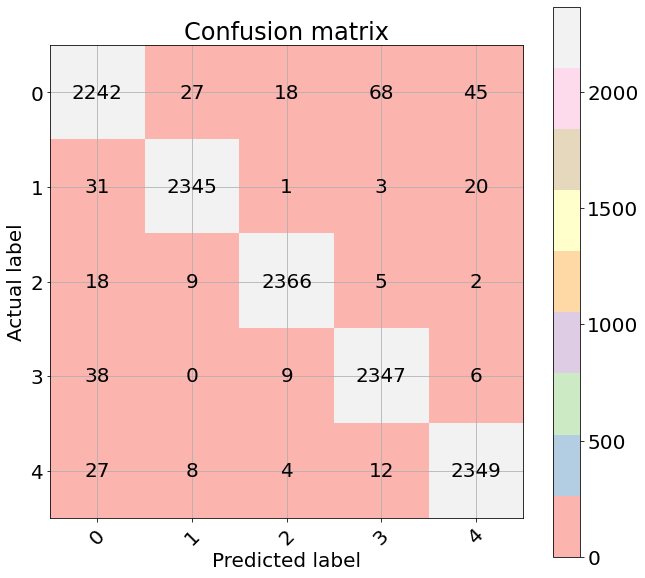

In [21]:
from sklearn import metrics
confusion = metrics.confusion_matrix(y_test, rf_predictions)
print(confusion)
plt.figure()
plot_confusion_matrix(confusion)
plt.show()

In [22]:
metrics.f1_score(y_test, rf_predictions, average='macro')

0.970700629790181

In [23]:
metrics.recall_score(y_test, rf_predictions, average='macro')

0.97075

In [24]:
metrics.precision_score(y_test, rf_predictions, average='macro')

0.9707141382522307

In [25]:
metrics.accuracy_score(y_test, rf_predictions)

0.97075

(4.0, 15.0)

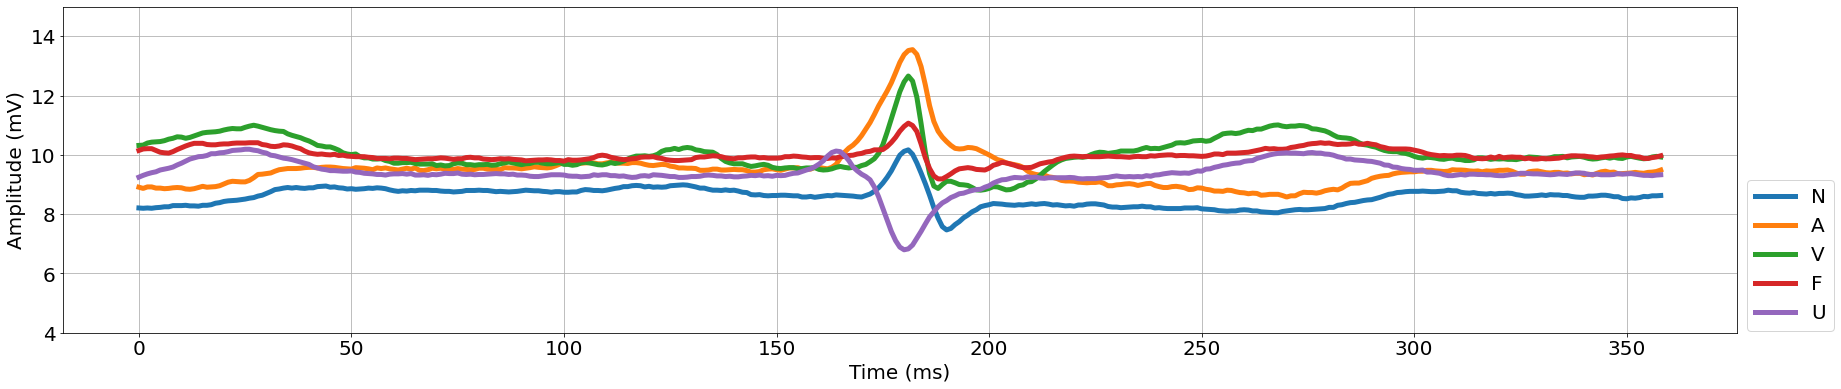

In [26]:
X_df.iloc[450,0:359].plot(linewidth=5)
X_df.iloc[7500,0:359].plot(linewidth=5)
X_df.iloc[15000,0:359].plot(linewidth=5)
X_df.iloc[21000,0:359].plot(linewidth=5)
X_df.iloc[27000,0:359].plot(linewidth=5)
plt.legend(labels=['N', 'A', 'V', 'F', 'U'], bbox_to_anchor=[1, 0.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (ms)')
plt.ylim(4,15)

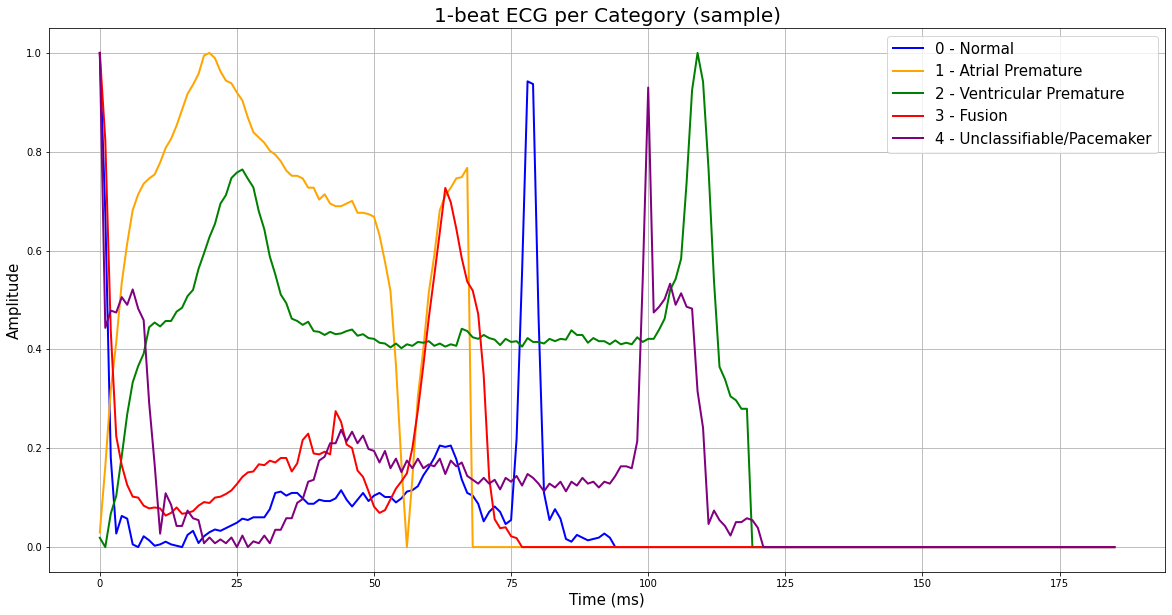

In [7]:
# x = np.arange(0, 187)*8/1000

# plt.figure(figsize=(20,10))

# for i in range(5):
#     plt.plot(mitbih_all_rs[mitbih_all_rs[187]==i].sample(1).iloc[0,:186], label=str(i) + ' - ' + classes[i], 
#              linewidth=2, color= col[i])

# plt.legend(prop={'size': 15})
# plt.title('1-beat ECG per Category (sample)', fontsize=20)
# plt.ylabel('Amplitude', fontsize=15)
# plt.xlabel('Time (ms)', fontsize=15)
# plt.show()

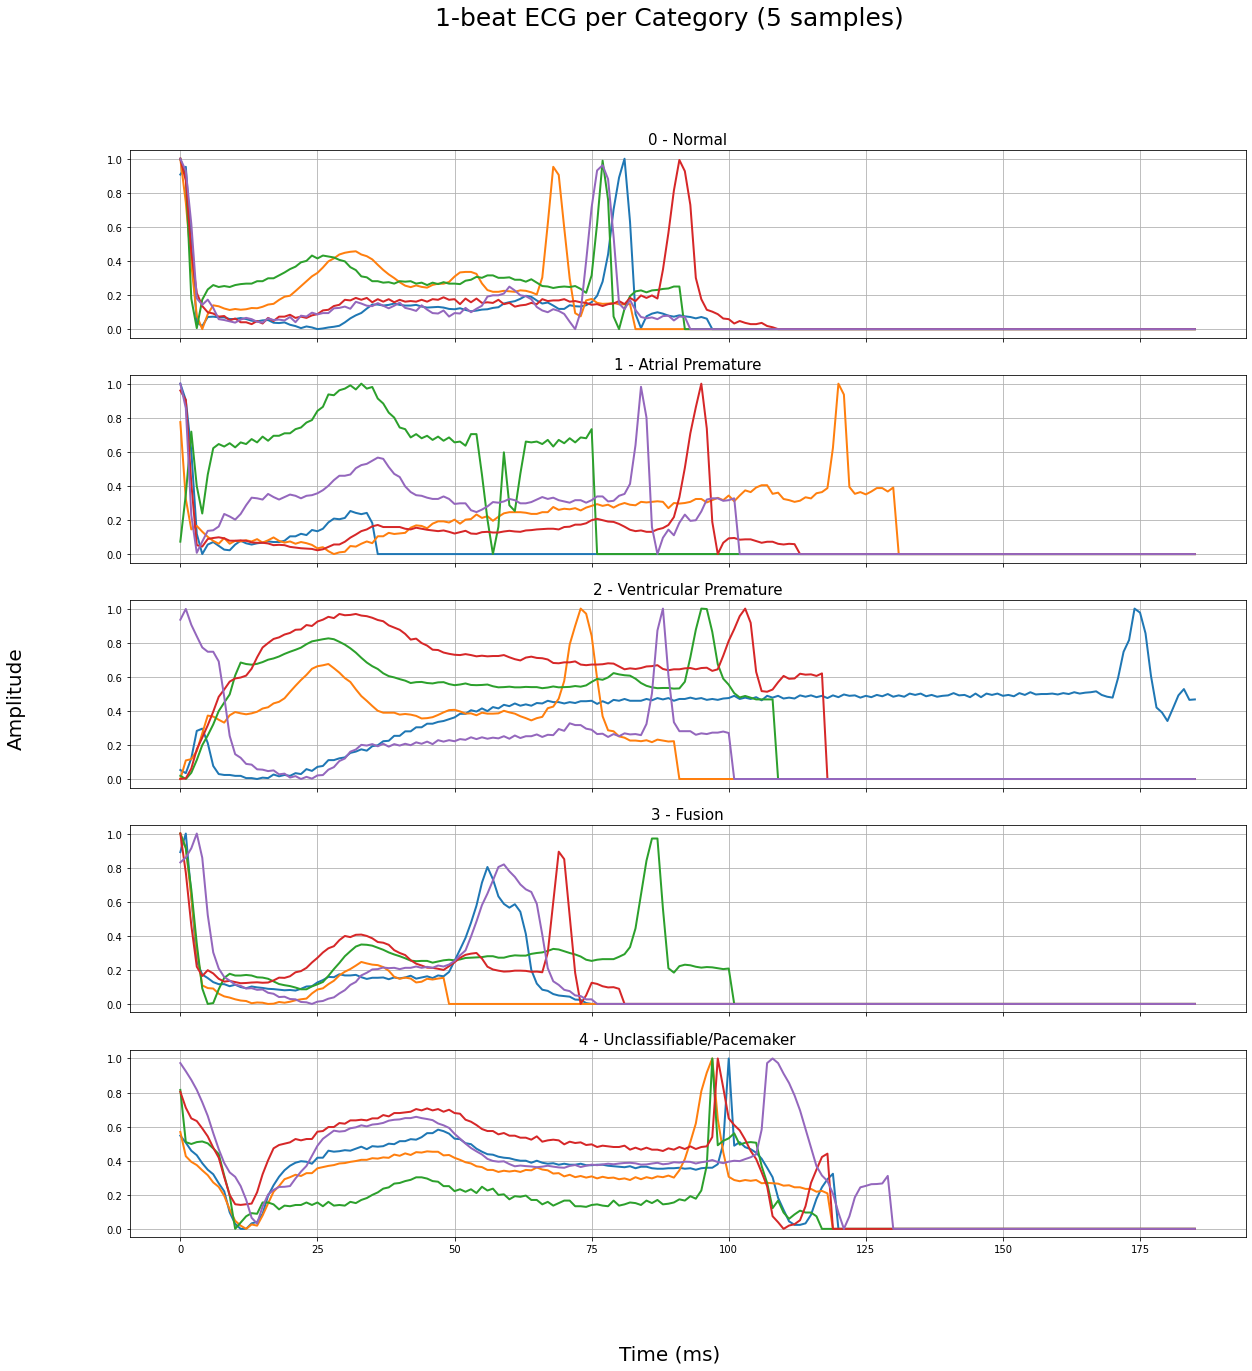

In [8]:
# figure, ax = plt.subplots(5, figsize=(20, 20), sharex=True, sharey=True)

# for i in range(5):
#     for s in range(5):
#         ax[i].plot(mitbih_all_rs[mitbih_all_rs[187]==i].sample(1).iloc[0,:186], 
#                linewidth=2)
#     ax[i].set_title(str(i) + ' - ' + classes[i], fontsize = 15)

# figure.suptitle('1-beat ECG per Category (5 samples)', fontsize = 25)
# figure.text(0.5, 0.04, 'Time (ms)', ha='center', fontsize=20)
# figure.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=20)

# plt.show()